<a href="https://colab.research.google.com/github/ggrindstaff/Connectivity/blob/Automated-Earthwork-Detection/Colab_notebooks/stockpond_detection_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies and import data

Install ripser package, cython dependency already available

In [1]:
#!pip install ripser
!git clone https://github.com/ggrindstaff/ripser.py
%cd ripser.py
!pip install -e .

Cloning into 'ripser.py'...
remote: Enumerating objects: 3437, done.
remote: Counting objects: 100% (416/416), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 3437 (delta 201), reused 340 (delta 169), pack-reused 3021
Receiving objects: 100% (3437/3437), 20.33 MiB | 17.75 MiB/s, done.
Resolving deltas: 100% (2002/2002), done.
/content/ripser.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ripser.py
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Building editable for ripser (pyproject.toml) ... done
  Created wheel for ripser: filename=ripser-0.6.2-0.editable-cp310-cp310-linux_x86_64.whl size=5992 sha256=e5

Code based on 
https://ripser.scikit-tda.org/en/latest/notebooks/Lower%20Star%20Image%20Filtrations.html

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib.transforms import Affine2D
import scipy
from scipy import ndimage
import PIL
import random


from persim import plot_diagrams, bottleneck, sliced_wasserstein, wasserstein, bottleneck_matching, PersImage,PersistenceImager, landscapes
from ripser import ripser, lower_star_img, Rips
from persim.persistent_entropy import *
from scipy import stats
from scipy import sparse


plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline 

In [3]:
def img_to_sparse(img):
  # Modified from source code
    m, n = img.shape

    idxs = np.arange(m * n).reshape((m, n))

    I = idxs.flatten()
    J = idxs.flatten()
    V = img.flatten()

    # Connect 8 spatial neighbors
    tidxs = np.ones((m + 2, n + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1] = idxs

    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:

            if di == 0 and dj == 0:
                continue

            thisJ = np.roll(np.roll(tidxs, di, axis=0), dj, axis=1)
            thisD = np.roll(np.roll(tD, di, axis=0), dj, axis=1)
            thisD = np.maximum(thisD, tD)

            # Deal with boundaries
            boundary = ~np.isnan(thisD)
            thisI = tidxs[boundary]
            thisJ = thisJ[boundary]
            thisD = thisD[boundary]

            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))

    return sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))


def cocycles_to_plot(cocycles,d,rotate=False):
  m,n = d.shape
  birthloc = [cocycles[0][i][0][0] for i in range(len(cocycles[0]))]
  xloc = []
  yloc = []
  for ind in birthloc:
    if rotate==False:
      yi = int(ind/n)
      xi = ind%n
    if rotate==True:
      yi = m-int(ind/n)-1
      xi = ind%n  
    xloc.append(xi)
    yloc.append(yi)
  return xloc,yloc


# Load data and compute persistence diagrams

Takes about 0.07 seconds per image, for 100x100 pixel images. For berm data, about 6 seconds per image.

In [4]:
directory = 'https://raw.githubusercontent.com/ggrindstaff/Connectivity/master/'#/content/Connectivity/Berms/'

files = ['landscape_clip_AOIs/AOI1_stockpond_clip.csv',
                
         ]
multfac = 1#e5
N=len(files)

import scipy.ndimage

dgm0 = {i:[] for i in range(N)} # output 0th homology data
dgm0_adj= {i:[] for i in range(N)} # output 0th homology data
dgm1 = {i:[] for i in range(N)} # output 1th homology data
data = {i:[] for i in range(N)} # DEM data for examples
data2 = {i:[] for i in range(N)} # DEM data with noise for examples
cocycles = {i:[] for i in range(N)}
# sigmas = {0:[3,3],2:[.5,.5],3:[.5,.5]}

for i in range(N):
  try:
    data[i] = np.loadtxt(directory+files[i],delimiter=",",skiprows=1)
  except:
    data[i] = np.loadtxt(directory+files[i],delimiter=" ",skiprows=0)
    data_temp = [data[i][j][2] for j in range(len(data[i]))]
    data_shape = [p for p in data[i] if p[1]==data[i][0][1]]
    data_shape = len(data_shape)
    data_shape1 = len(data_temp)/data_shape
    data_temp = np.array(data_temp).reshape(int(data_shape1),int(data_shape))
    data[i] = data_temp
  if i>3:
    d = ndimage.interpolation.zoom(data[i],.5) #decimate resolution
  else:
    d = data[i]
  data2[i] = d + 1e-15*np.random.rand(d.shape[0],d.shape[1])
  if 'stockpond' in files[i]:
    sparseDM = img_to_sparse(data2[i])
    rip = ripser(sparseDM, distance_matrix=True, maxdim=0, do_cocycles=True)
    dgm0[i] = rip["dgms"][0]
    cocycles[i] = rip["cocycles"]
  else:
    sparseDM = img_to_sparse(data2[i])
    rip = ripser(-sparseDM, distance_matrix=True, maxdim=0, do_cocycles=True)
    dgm0[i] = rip["dgms"][0]
    cocycles[i] = rip["cocycles"]

#Plot cycle locations

<ipython-input-5-a616df6f99db>:134: RuntimeWarning: divide by zero encountered in double_scalars
  heightratio = persheight / meanheight
<ipython-input-5-a616df6f99db>:148: RuntimeWarning: divide by zero encountered in double_scalars
  feature_width = feature_size / feature_length


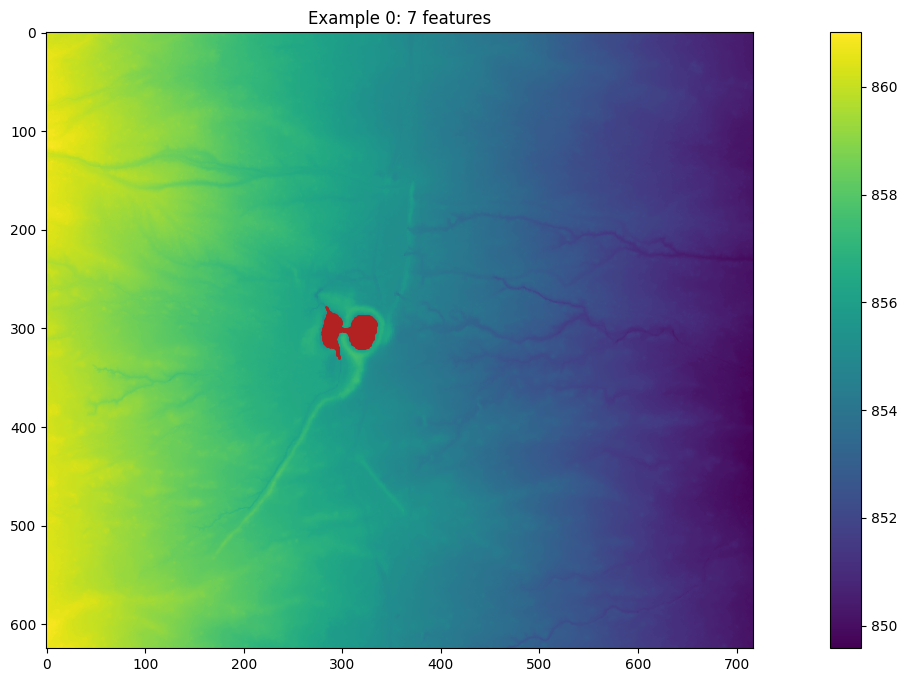

In [5]:
# plot cycle locations on DEM data
from scipy.spatial.distance import pdist, squareform
from skimage import measure
from skimage import filters

thresh = 1 
max_thresh = 3


noisethresh = 5

minsize = 100
maxsize = 1000
maxsize_stockpond = 2000
minlength = 40
maxlength = 200
maxwidth = 11
minhratio = 2.
maxhratio = 4.

xcycles = {i:[] for i in range(N)}
ycycles = {i:[] for i in range(N)}
feature_idx = {i:[] for i in range(N)}
nonoise_idx = {i:[] for i in range(N)}
maskfinal_all = {i:[] for i in range(N)}

for i in range(len(files)):
  
  if 'stockpond' in files[i]:
    berm = False
    dgm = dgm0[i]
    idxs = np.arange(dgm.shape[0])
    idxs = idxs[np.abs(dgm[:, 1] - dgm[:, 0]) > thresh]

  else:
    berm = True
    dgm = dgm0[i]
    idxs = np.arange(dgm0[i].shape[0])
    idxs = idxs[np.abs(dgm0[i][:, 1] - dgm0[i][:, 0]) > thresh]


  xvals, yvals = cocycles_to_plot(cocycles[i],data2[i],rotate=False)
  xcycle, ycycle = np.array(xvals), np.array(yvals)
  mask1 = (xcycle>noisethresh)&(xcycle<len(data2[i][0])-noisethresh)&(ycycle>noisethresh)&(ycycle<len(data2[i])-noisethresh)
  nonoise_idx[i] = mask1
  xcycle = np.array(xvals)[idxs]
  ycycle = np.array(yvals)[idxs]
  mask = (xcycle>noisethresh)&(xcycle<len(data2[i][0])-noisethresh)&(ycycle>noisethresh)&(ycycle<len(data2[i])-noisethresh)
  dgm_use = dgm[idxs][mask]
  xcycle = xcycle[mask]
  ycycle = ycycle[mask]
  xcycles[i] = xcycle
  ycycles[i] = ycycle
  feature_idx[i] = idxs[mask]

  plt.figure(figsize = (20,8))
  shw = plt.imshow(data2[i], cmap = 'viridis')
  if i==6:
    shw = plt.imshow(data2[i],cmap='viridis',vmin=997,vmax = 1007)
  # plt.scatter(xcycle,ycycle,c='k', marker='x')
  plt.title('Example ' + str(i) +': '+str(len(xcycle))+' features')


  # plot features not as stars but as the identified areas

  dgm = dgm_use
  births_berm = np.array([p[0] for p in dgm])
  # births_berm = births_berm[mask_feature]
  deaths_berm = np.array([p[1] for p in dgm])
  # deaths_berm = deaths_berm[mask_feature]

  if births_berm[0]<0:
      deaths_berm1 = births_berm
      births_berm = -(deaths_berm)
      deaths_berm = -deaths_berm1
  elif (births_berm[0]>0) & (not berm):
    deaths_berm = (deaths_berm-births_berm)*.75+births_berm
  maskfinal = []
  for l in range(len(xcycle)):
    
    
    splot = np.where((data2[i]<=deaths_berm[l]) & (data2[i]>=births_berm[l]),1,0)



    dist = 10

    all_labels = measure.label(splot)
    blobs_labels = measure.label(splot, background=0)

    poss_comps = list(set(blobs_labels[ycycle[l]-dist:ycycle[l]+dist,
                                       max(0,xcycle[l]-dist):xcycle[l]+dist].flatten()))
    poss_comps = [p for p in poss_comps if p>0]

    if len(poss_comps)==0:
        dist1 = dist*2
        poss_comps = list(set(blobs_labels[ycycle[l]-dist:ycycle[l]+dist1,
                                           max(0,xcycle[l]-dist):xcycle[l]+dist].flatten()))
        poss_comps = [p for p in poss_comps if p>0]
    if len(poss_comps)>1:
      dist1 = int(dist/2)
      poss_comps = list(set(blobs_labels[ycycle[l]-dist:ycycle[l]+dist1,
                                         max(0,xcycle[l]-dist):xcycle[l]+dist].flatten()))
      poss_comps = [p for p in poss_comps if p>0]
      if len(poss_comps)>1:
        dist1 = int(dist/4)
        poss_comps = list(set(blobs_labels[ycycle[l]-dist:ycycle[l]+dist1,
                                           max(0,xcycle[l]-dist):xcycle[l]+dist].flatten()))
        poss_comps = [p for p in poss_comps if p>0]
      if len(poss_comps)==0:
        dist1 = int(dist)
        poss_comps = list(set(blobs_labels[ycycle[l]-dist:ycycle[l]+dist1,
                                           max(0,xcycle[l]-dist):xcycle[l]+dist].flatten()))
        poss_comps = [p for p in poss_comps if p>0]

    if len(poss_comps)>1:
      poss_comps = [p for p in poss_comps if p>1]

    blob_thisonly = np.where(blobs_labels==poss_comps[0],1,np.nan)

    splot_height = data2[i][blobs_labels==poss_comps[0]]
    meanheight = splot_height-np.nanmin(splot_height)
    meanheight = np.nanmean(meanheight)
    persheight = deaths_berm[l]-births_berm[l]
    heightratio = persheight / meanheight
    

    # ax.imshow(blob_thisonly, cmap='Reds_r',vmax=1,zorder = 100)
    # instead, plot as scatter points so it can be bolder
    blob_points = np.argwhere(~np.isnan(blob_thisonly))
    blob_ys = [p[0] for p in blob_points]
    blob_xs = [p[1] for p in blob_points]

    # filter based on size and length
    feature_size = len(blob_points)
    D = pdist(blob_points)
    D = squareform(D)
    feature_length, [I_row, I_col] = np.nanmax(D), np.unravel_index( np.argmax(D), D.shape )
    feature_width = feature_size / feature_length
    # print(N)
    if (berm) & (feature_size>minsize) & (feature_size<maxsize) &(feature_length>minlength) & (feature_length<maxlength) & (feature_width<maxwidth) & (heightratio>minhratio) & (heightratio<maxhratio):
      plt.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1)
      # print(l, feature_size, feature_length, feature_width)
      print(persheight,meanheight,heightratio)
      maskfinal.append(True)
    elif (not berm) & (feature_size>minsize) & (feature_size<maxsize_stockpond) &(feature_length>minlength) & (feature_length<maxlength):
      plt.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1)
        # print(l, feature_size, feature_length, )
      maskfinal.append(True)
    else:
      maskfinal.append(False)

  maskfinal_all[i] = maskfinal
    
    # else:
    #   plt.scatter(blob_xs, blob_ys, c = 'violet', s = 1)
    


  # plt.axis('off')
  plt.colorbar(shw)
  plt.show()

<ipython-input-9-df38a2e9732d>:117: RuntimeWarning: divide by zero encountered in double_scalars
  feature_width = feature_size / feature_length


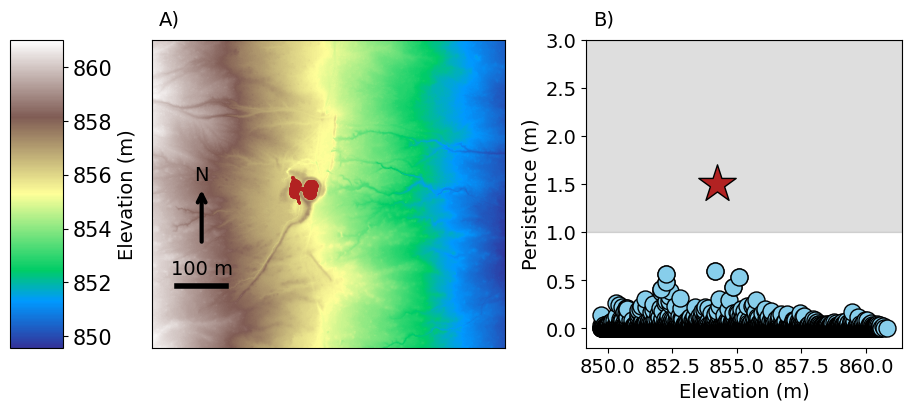

In [9]:
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams.update({'font.size': 14})

from skimage import measure
from skimage import filters

cmap='terrain'

fig2 = plt.figure(constrained_layout=True, figsize = (9,4))
spec2 = gridspec.GridSpec(ncols=14, nrows=1, figure=fig2)
#colorbars
ax0  = fig2.add_subplot(spec2[0, 0])
# elevation maps
ax1 = fig2.add_subplot(spec2[0, 1:8]) 
# persistence diagrams
ax6 = fig2.add_subplot(spec2[0, 8:]) 


axs = [[ax0,  ax1, ax6],
      #  [ax01, ax2, ax7],
       ]
scale_y = [500,]
scale_x = [100,]
dataind = [3]
label0=['A)',]
label1 = ['B)']
tick_font_size = 15
dataind = [0]


for i in range(1):
  berm = False

  ax = axs[i][1]
  d = data2[dataind[i]]
  terr = ax.imshow(d,cmap = cmap)
  cbar = plt.colorbar(terr, cax = axs[i][0])
  cbar.set_label('Elevation (m)')
  cbar.ax.tick_params(labelsize=tick_font_size)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.plot([scale_x[i]-50,scale_x[i]+50],[scale_y[i]]*2,lw=4,c = 'k')
  ax.text(scale_x[i],scale_y[i]*0.95,'100 m',horizontalalignment='center')
  ax.annotate('N', (scale_x[i], scale_y[i]*0.83),
            xytext=(scale_x[i], scale_y[i]*0.57),
             arrowprops=dict(facecolor='black', 
                             arrowstyle='<-',
                             lw = 3),ha='center')

  xcycle = xcycles[dataind[i]]
  ycycle = ycycles[dataind[i]]
  dgm = dgm0[dataind[i]]
  mask_feature = feature_idx[dataind[i]]
  births_berm = np.array([p[0] for p in dgm])
  births_berm = births_berm[mask_feature]
  deaths_berm = np.array([p[1] for p in dgm])
  deaths_berm = deaths_berm[mask_feature]

  if births_berm[0]<0:
    deaths_berm1 = births_berm
    births_berm = -(deaths_berm)
    deaths_berm = -deaths_berm1
  elif (births_berm[0]>0) & (not berm):
    deaths_berm = (deaths_berm-births_berm)*.75+births_berm

  for l in range(len(xcycle)):
    splot = np.where((data2[dataind[i]]<=deaths_berm[l]) & (data2[dataind[i]]>=births_berm[l]),1,0)



    dist = 10

    all_labels = measure.label(splot)
    blobs_labels = measure.label(splot, background=0)

    poss_comps = list(set(blobs_labels[ycycle[l]-dist:ycycle[l]+dist,
                                       max(0,xcycle[l]-dist):xcycle[l]+dist].flatten()))
    poss_comps = [p for p in poss_comps if p>0]

    if len(poss_comps)==0:
        dist1 = dist*2
        poss_comps = list(set(blobs_labels[ycycle[l]-dist:ycycle[l]+dist1,
                                           max(0,xcycle[l]-dist):xcycle[l]+dist].flatten()))
        poss_comps = [p for p in poss_comps if p>0]
    if len(poss_comps)>1:
      dist1 = int(dist/2)
      poss_comps = list(set(blobs_labels[ycycle[l]-dist:ycycle[l]+dist1,
                                         max(0,xcycle[l]-dist):xcycle[l]+dist].flatten()))
      poss_comps = [p for p in poss_comps if p>0]
      if len(poss_comps)>1:
        dist1 = int(dist/4)
        poss_comps = list(set(blobs_labels[ycycle[l]-dist:ycycle[l]+dist1,
                                           max(0,xcycle[l]-dist):xcycle[l]+dist].flatten()))
        poss_comps = [p for p in poss_comps if p>0]
      if len(poss_comps)==0:
        dist1 = int(dist)
        poss_comps = list(set(blobs_labels[ycycle[l]-dist:ycycle[l]+dist1,
                                           max(0,xcycle[l]-dist):xcycle[l]+dist].flatten()))
        poss_comps = [p for p in poss_comps if p>0]

    if len(poss_comps)>1:
      poss_comps = [p for p in poss_comps if p>1]

    blob_thisonly = np.where(blobs_labels==poss_comps[0],1,np.nan)

    blob_points = np.argwhere(~np.isnan(blob_thisonly))
    blob_ys = [p[0] for p in blob_points]
    blob_xs = [p[1] for p in blob_points]
    
    # filter based on size and length
    feature_size = len(blob_points)
    if feature_size<maxsize_stockpond:
      D = pdist(blob_points)
      D = squareform(D)
      feature_length, [I_row, I_col] = np.nanmax(D), np.unravel_index( np.argmax(D), D.shape )
      feature_width = feature_size / feature_length
      
      if (berm) & (feature_size>minsize) & (feature_size<maxsize) &(feature_length>minlength) & (feature_length<maxlength) & (feature_width<maxwidth):
        ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1, label = None)
      if (not berm) & (feature_size>minsize) & (feature_size<maxsize_stockpond) &(feature_length>minlength) & (feature_length<maxlength):
        ax.scatter(blob_xs, blob_ys, c = 'firebrick', s = 1, label = None)


  ax.plot([0,0],[0,0],c='firebrick',lw=4,label='ID',zorder = -1)
  ax.plot([0,0],[0,0],c='white',lw=4,label='Manual ID',zorder = -1)
  # if i==0:
  #   ax.legend()


  ax.text(0.02,1.05,label0[i],transform = ax.transAxes)
  
  # plot persistence diagrams
  ax = axs[i][2]
  dgm = dgm0[dataind[i]]
  birth = np.array([p[0] for p in dgm])
  death = np.array([p[1] for p in dgm])
  pers = death-birth
  mask_feature = feature_idx[dataind[i]]
  mask1 = nonoise_idx[dataind[i]]
  birthplotfeature = birth[mask_feature]
  persplotfeature = pers[mask_feature]

  t = 0.6
  birth = birth[pers<t]
  mask1 = mask1[pers<t]
  pers = pers[pers<t]

  ax.scatter(birth[mask1],
             pers[mask1],
             c='skyblue',edgecolor = 'k',
             s = 150,
             )
  detect_mask = maskfinal_all[dataind[i]]
  ax.scatter(birthplotfeature[detect_mask],persplotfeature[detect_mask],
             label = 'identified\nfeatures',
             c='firebrick',edgecolor = 'k',s=800,
             marker = '*',)
  ax.scatter(birthplotfeature[~np.array(detect_mask)],
            persplotfeature[~np.array(detect_mask)],
            label = None,
            c='skyblue',edgecolor = 'k',
             s = 150)
  ax.set_ylabel('Persistence (m)')
  ax.axhspan(1,max_thresh,facecolor='k',alpha=0.13,edgecolor = 'k',zorder = -1)
  
  # if i==0:
  #   ax.legend(loc='upper left',)
  ax.set_xlabel('Elevation (m)')
  ax.text(0.02,1.05,label1[i],transform = ax.transAxes)
  ax.set_ylim(-.2,3)

plt.savefig('/content/stockpond_detection.png',format='png',
            dpi=300,bbox_inches='tight')